# Building a core/shell nanoparticle

Let's build a core/shell nanoparticle with a simple cubic structure using a python script.

Import the required libraries

* [numpy](http://www.numpy.org/) handles numeric arrays and mathematical operations.
* [product](https://docs.python.org/3.7/library/itertools.html#itertools.product) returns cartesian product of input iterables.
* [matplotlib](https://matplotlib.org/) produces figures.
* [defaultdict](https://docs.python.org/3.7/library/collections.html#collections.defaultdict) is a dictionary where each *value* has a defined type.

In [1]:
import numpy
from itertools import product
from matplotlib import pyplot
from collections import defaultdict

Define the values of the core (```Rc```) and nanoparticle (```R```) radius measured in magnetic unit cells (muc). Each site is a magnetic moment.

In [2]:
Rc = 7.5
R = 10.5

Define the core (```sc```) and shell (```ss```) spin values, the core (```kc```) and shell (```ks```) anisotropy constants, the core-core (```jcc```), core-shell (```jint```) and shell-shell (```jss```) exchange interaction constants, and the [spin update policy](https://pcm-ca.github.io/vegas/spin-update-policies/) for the direction of the magnetic moments. Because the atomic magnetic moment is taken as $1.0$, it should be considered in the units of the magnetic field in a simulation. ```jcc = 1.0``` is taken as the unit of energy (see [Dimitriadis et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.064420)). 


In [3]:
ss = sc = 1.0
jcc = 1.0
kc = 0.1 * jcc
ks = 0.5 * jcc
jint = -0.5 * jcc
jss = -0.5 * jcc
update_policy = "adaptive"

Create a dictionary to easily retrieve the parameters defined above.

In [4]:
spin = {
    "core": sc,
    "core_interface": sc,
    "shell": ss,
    "shell_interface": ss,
}

kan = {
    "core": kc,
    "core_interface": kc,
    "shell": ks,
    "shell_interface": ks,
}

jex = {
    ("core", "core"): jcc,
    ("core", "shell"): jint,
    ("shell", "core"): jint,
    ("shell", "shell"): jss
}

Create a list of sites and assign them as core or shell ions according to ```Rc```.

In [5]:
sites = list()
core_sites = list()
shell_sites = list()
for site in product(range(-int(numpy.ceil(R+1)), int(numpy.ceil(R+1))),
                    range(-int(numpy.ceil(R+1)), int(numpy.ceil(R+1))),
                    range(-int(numpy.ceil(R+1)), int(numpy.ceil(R+1)))):
    dist = numpy.linalg.norm(site)
    if dist <= R:
        sites.append(site)
        if dist <= Rc:
            core_sites.append(site)
        else:
            shell_sites.append(site)

Convert the previous list to numpy arrays in order to produce a midplane cross-section for $y=0$.

In [6]:
all_positions = numpy.array(sites)
core_positions = numpy.array(core_sites)
shell_positions = numpy.array(shell_sites)
core_positions = core_positions[core_positions[:, 1] == 0]
shell_positions = shell_positions[shell_positions[:, 1] == 0]

Generate a plot of the midplane cross-section using different colors for the core and the shell ions.

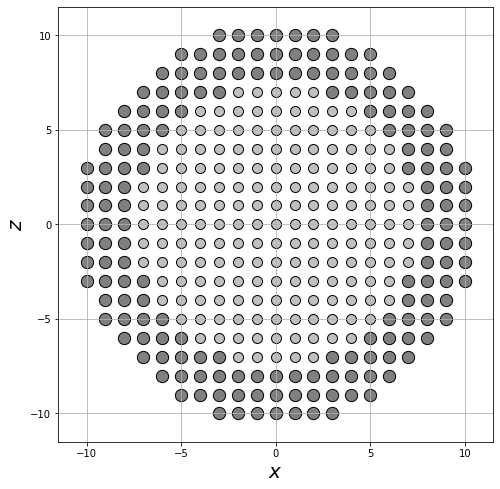

In [7]:
pyplot.figure(figsize=(8, 8))
pyplot.scatter(core_positions[:, 0], core_positions[:, 2], s=100, color="silver", edgecolor="black")
pyplot.scatter(shell_positions[:, 0], shell_positions[:, 2], s=150, color="gray", edgecolor="black")
pyplot.grid()
pyplot.xlabel(r"$x$", fontsize=20)
pyplot.ylabel(r"$z$", fontsize=20)
pyplot.xlim(-R-1, R+1)
pyplot.ylim(-R-1, R+1)
pyplot.gca().set_aspect("equal")
pyplot.show()

Identify the neighbors of each magnetic moment and store them in a dictionary.

In [8]:
nhbs = defaultdict(list)
for site in sites:
    x, y, z = site
    for dx, dy, dz in [(1, 0, 0), (-1, 0, 0),
                       (0, 1, 0), (0, -1, 0),
                       (0, 0, 1), (0, 0, -1)]:
        nhb = ((x + dx), (y + dy), (z + dz))
        if nhb in sites:
            nhbs[site].append(nhb)

Make some verifications: that each site has a maximum of $6$ neighbors, that the neighbors of each site are $1$ muc away, and that each site is in the neighbors list of each of its neighbors.

In [9]:
for site in sites:
    assert len(nhbs[site]) <= 6
    for nhb in nhbs[site]:
        assert numpy.linalg.norm(numpy.array(site) - numpy.array(nhb)) == 1.0
        assert site in nhbs[nhb]

Create a dictionary to identify the type of each site, which can be ```core```, ```shell```, ```core_interface``` and ```shell_interface```, which corresponds to sites located in the core, the shell, the core interface and the shell interface, respectively.

In [10]:
types = dict()
for site in sites:
    prefix = "core" if site in core_sites else "shell"
    for nhb in nhbs[site]:
        nhb_prefix = "core" if nhb in core_sites else "shell"
        if prefix != nhb_prefix:
            prefix += "_interface"
            break
    types[site] = prefix

Create a dictionary to store all the sites of each type.

In [11]:
positions = defaultdict(list)
for site in sites:
    positions[types[site]].append(site)

Verify that there are only four ion types.

In [12]:
positions.keys()

dict_keys(['shell', 'shell_interface', 'core_interface', 'core'])

Again, convert the sites list to numpy arrays in order to produce a midplane cross-section for $y=0$.

In [13]:
core = numpy.array(positions["core"])
shell = numpy.array(positions["shell"])
core_interface = numpy.array(positions["core_interface"])
shell_interface = numpy.array(positions["shell_interface"])
core = core[core[:, 1] == 0]
shell = shell[shell[:, 1] == 0]
core_interface = core_interface[core_interface[:, 1] == 0]
shell_interface = shell_interface[shell_interface[:, 1] == 0]

Generate a graphic of the midplane cross-section using different colors for the core, shell, core interface and shell interface ions.

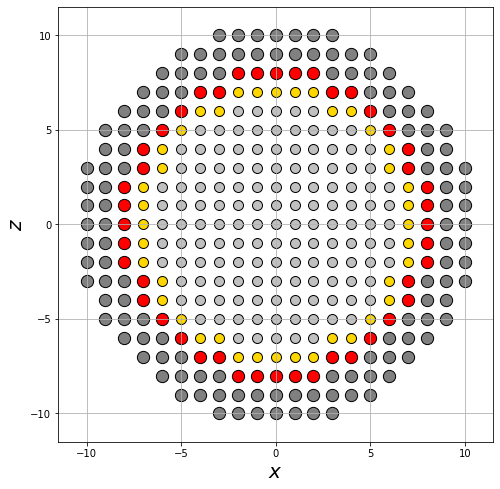

In [14]:
pyplot.figure(figsize=(8, 8))
pyplot.scatter(core[:, 0], core[:, 2], s=100, color="silver", edgecolor="black")
pyplot.scatter(shell[:, 0], shell[:, 2], s=150, color="gray", edgecolor="black")
pyplot.scatter(core_interface[:, 0], core_interface[:, 2], s=100, color="gold", edgecolor="black")
pyplot.scatter(shell_interface[:, 0], shell_interface[:, 2], s=150, color="red", edgecolor="black")
pyplot.grid()
pyplot.xlabel(r"$x$", fontsize=20)
pyplot.ylabel(r"$z$", fontsize=20)
pyplot.xlim(-R-1, R+1)
pyplot.ylim(-R-1, R+1)
pyplot.gca().set_aspect("equal")
pyplot.show()

Define the anisotropy and external magnetic field axes for each site, which in this case is the $z$ axis for all the ions.

In [15]:
anisotropy_axis = dict()
field_axis = dict()
for site in sites:
    anisotropy_axis[site] = (0.0, 0.0, 1.0)
    field_axis[site] = (0.0, 0.0, 1.0)

Count the number of interactions equal to the sum of the neighbors of each site, and the number of sites as the length of the list of the sites.

In [16]:
num_interactions = 0
for site in sites:
    num_interactions += len(nhbs[site])
num_sites = len(sites)

Create the files to store the structural properties (```sample.dat```) and the anisotropy (```anisotropy.dat```) of the sample.

In [17]:
sample_file = open("sample.dat", mode="w")
anisotropy_file = open("anisotropy.dat", mode="w")

Write in the first line of *sample_file* the number of sites, interactions and types:

In [18]:
sample_file.write("{} {} {}\n".format(num_sites, num_interactions, len(set(types.values()))))
print(num_sites, num_interactions, len(set(types.values())))

4945 27576 4


Write the ion types on a different line each one.

In [19]:
for t in sorted(set(types.values())):
    sample_file.write("{}\n".format(t))
    print(t)

core
core_interface
shell
shell_interface


Write the parameters of each site according to the established [format](https://pcm-ca.github.io/vegas/system-building/).

In [20]:
for site in sites:
    i = sites.index(site)
    t = types[site]
    sample_file.write("{} {} {} {} {} {} {} {} {} {}\n".format(i, *site, spin[t], *field_axis[site], t, update_policy))
    anisotropy_file.write("{} {} {} {}\n".format(*anisotropy_axis[site], kan[t]))

Write the exchange interactions between every pair of neighbors.

In [21]:
for site in sites:
    t = types[site]
    for nhb in nhbs[site]:
        nhb_t = types[nhb]
        sample_file.write("{} {} {}\n".format(
            sites.index(site), sites.index(nhb),
            jex[(t.split("_")[0], nhb_t.split("_")[0])]))

Close the files.

In [22]:
sample_file.close()
anisotropy_file.close()

## Creating an initial state file

When a magnetic system is simulated in 𝕍egas, the initial magnetization state of the system can be a random state or a state inputed by the user. 

Let's look at a case where the user needs to input the initial magnetization state: In simulations of exchange bias in core/shell nanoparticles, it is necessary to cool down the nanoparticle from a temperature between the Néel temperature of the antiferromagnetic shell ($T_N$) and the Curie temperature of the ferromagnetic core ($T_C$), in presence of an external magnetic field ($H_{max}$), to a very low temperature $T_{sim}$. However, this cooling process can be avoided using an energy minimization procedure. The ferromagnetic core ions are first oriented along the $+z$ direction, indicating the desired core orientation at positive field saturation. The antiferromagnetic shell is then set with one of two polarities, AFM+ and AFM−, indicating whether alternate atoms in the lattice are up-down-up-down or down-up-down-up. For each of the polarities the total system energy is calculated, and the polarity with the lowest energy is then selected. This process ensured a left shift of the hysteresis loop for all particles, consistent with the setting of a fully saturated exchange-bias system (see [Evans et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.092404)). 

Let's implement this energy minimization procedure in the current python script.

Define a function to calculate the energy of the system in presence of an external magnetic field ```Hmax```:


In [23]:
Hmax = 1.0

In [24]:
def energy(state, Hmax):
    E_exchange = 0.0
    E_other = 0.0
    for i, site in enumerate(sites):
        t = types[site].split("_")[0]
        for nbh in nhbs[site]:
            t_nbh = types[nbh].split("_")[0]
            E_exchange -= state[i] * state[sites.index(nbh)] * jex[(t, t_nbh)]
        E_other -= (Hmax * state[i] + (kan[t] * state[i])**2)
    return 0.5 * E_exchange + E_other


Create one of the two possible magnetization states where the orientation of the spin moments in the shell are  $\uparrow \downarrow \uparrow \downarrow$ and in the core are $\uparrow \uparrow \uparrow \uparrow$:

In [25]:
state1 = list()
for site in sites:
    if types[site].split("_")[0] == "shell":
        if sum(site) % 2 == 0:
            state1.append(-1.0)
        else:
            state1.append(1.0)
    else:
        state1.append(1.0)
        
state1 = numpy.array(state1)

And create the other possible magnetization state where the orientation of the spin moments in the shell are  $\downarrow \uparrow \downarrow \uparrow$ and in the core are $\uparrow \uparrow \uparrow \uparrow$:

In [26]:
state2 = list()
for site in sites:
    if types[site].split("_")[0] == "shell":
        if sum(site) % 2 == 0:
            state2.append(1.0)
        else:
            state2.append(-1.0)
    else:
        state2.append(1.0)

state2 = numpy.array(state2)

In order to visualize both magnetization states, create midplane cross-section for $y=0$:

In [27]:
directions1 = state1[all_positions[:, 1] == 0]
layer1 = all_positions[all_positions[:, 1] == 0]
x1, y1, z1 = layer1.T

directions2 = state2[all_positions[:, 1] == 0]
layer2 = all_positions[all_positions[:, 1] == 0]
x2, y2, z2 = layer1.T

Plot both midplane cross-sections. In both cases the core ions are oriented along the $+z$ direction, while the the shell ions are alternated in different ways, as expected.

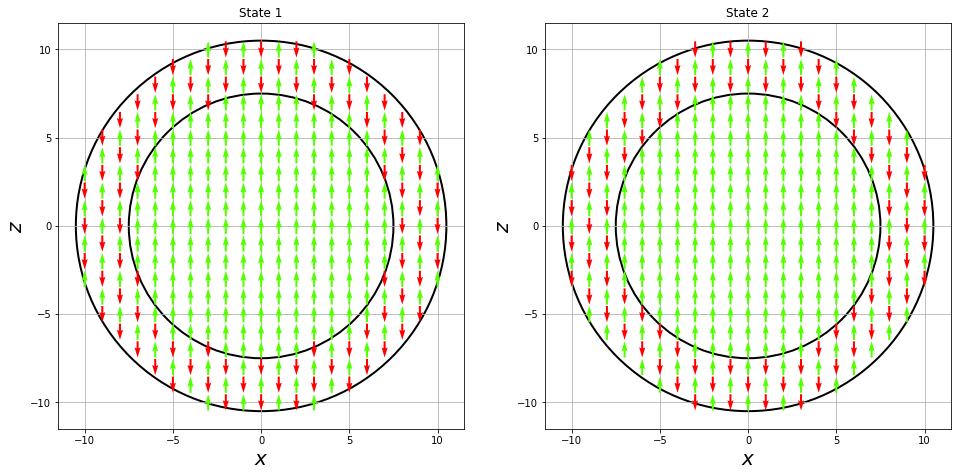

In [28]:
fig = pyplot.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.add_artist(pyplot.Circle((0, 0), Rc, color='black', fill=False, lw=2))
ax1.add_artist(pyplot.Circle((0, 0), R, color='black', fill=False, lw=2))
ax1.quiver(x1, z1, 0, directions1, directions1, pivot="middle",
           cmap="prism", scale=25, width=0.005, lw=0.5, zorder=10)
ax1.set_title("State 1")

ax2.add_artist(pyplot.Circle((0, 0), Rc, color='black', fill=False, lw=2))
ax2.add_artist(pyplot.Circle((0, 0), R, color='black', fill=False, lw=2))
ax2.quiver(x2, z2, 0, directions2, directions2, pivot="middle",
           cmap="prism", scale=25, width=0.005, lw=0.5, zorder=10)
ax2.set_title("State 2")

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlabel(r"$x$", fontsize=20)
    ax.set_ylabel(r"$z$", fontsize=20)
    ax.set_xlim(-R-1, R+1)
    ax.set_ylim(-R-1, R+1)
    ax.set_aspect("equal")
pyplot.show()

Call the function ```energy``` to compute the energy of the two magnetization states.

In [29]:
print("state1: ", energy(state1, Hmax))
print("state2: ", energy(state2, Hmax))

state1:  -11186.410000000056
state2:  -11576.41000000005


In this case, the magnetization state ```state2``` minimizes the energy. However, this could change for nanoparticles of different size. Then, it is always recommended to compute and compare both energies.

In [30]:
state = state1 if energy(state1, Hmax) <= energy(state2, Hmax) else state2

Finally, create the file to store the initial state of the nanoparticle (```initialstate.dat```):

In [31]:
initialstate_file = open("initialstate.dat", mode="w")

for i, site in enumerate(sites):
    initialstate_file.write("{} {} {}\n".format(0.0, 0.0, state[i]))

initialstate_file.close()

The result of this script is the creation of three files: ```sample.dat```, ```anisotropy.dat``` and ```initialstate.dat```, which store the structural properties, the anisotropy and the initial magnetic state of the core/shell nanoparticle.